# Plots for the 2MDM analysis

In [80]:
import warnings
warnings.filterwarnings("ignore", message="numpy.dtype size changed")
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns
from auxPlots import columnsDict
import itertools
from scipy.interpolate import griddata

pd.option_context('display.max_columns', None)
pd.option_context('display.max_rows', None)

pd.options.mode.chained_assignment = None #Disable copy warnings
# plt.style.use('fivethirtyeight') #Set style
# mpl.rcParams.update({'figure.figsize' : (15,10)})  #Set general plotting options
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "sans-serif",
    "font.sans-serif": ["Helvetica"]})

plt.rcParams.update({"savefig.dpi" : 300}) #Figure resolution


#Define plotting style:
sns.set_style('ticks',{'font.family':'Times New Roman', 'font.serif':'Times New Roman'})
sns.set_context('paper', font_scale=1.8)
cm = plt.colormaps['RdYlBu']

#### Get data in pcl format and print all columns names

In [81]:
#Merge with SModelS DataFrame
pclFiles = ['../data/smodels_results.pcl']
dfs = [pd.read_pickle(i) for i in pclFiles]
dataDF = pd.concat(dfs, ignore_index=True)
dataDF.rename(columns=columnsDict,inplace=True)
dropCols = [c for c in dataDF.columns if ('Output' in c or 'weight' in c)]
dataDF.drop(columns=dropCols,inplace=True)
dataDF.set_index('filename',drop=True,inplace=True)
print(dataDF.columns.values.tolist()) #Print all columns names

['mChi', 'mS', 'mZp', 'mass.9000002', 'mass.9000003', 'mass.9000004', 'mass.9000005', 'width.9000002', 'width.9000003', 'width.9000004', 'width.9000005', 'width.9000006', 'width.9900026', 'width.9900032', 'gchi', 'gq', 'sina', 'extpar.4', 'xsec8TeV(fb).9900032', 'xsec8TeV(fb).9900026', 'xsec13TeV(fb).9900032', 'xsec13TeV(fb).9900026', 'BRs.sd.W-,W+', 'BRs.sd.higgs,higgs', 'BRs.sd.Z,Z', 'BRs.sd.t-,t+', 'BRs.sd.chi,chi', 'BRs.sd.ta+,ta-', 'BRs.zp.chi,chi', 'BRs.zp.c,c', 'BRs.zp.q,q', 'BRs.zp.b,b', 'BRs.zp.t-,t+', 'totalxsec13TeV(fb)', 'totalxsec8TeV(fb)', 'CombinedRes', 'Total xsec for missing topologies (fb)', 'Total xsec for missing topologies with displaced decays (fb)', 'Total xsec for missing topologies with prompt decays (fb)', 'Total xsec for topologies outside the grid (fb)', 'ExptRes.result0.maxcond', 'ExptRes.result0.theory prediction (fb)', 'ExptRes.result0.upper limit (fb)', 'ExptRes.result0.expected upper limit (fb)', 'ExptRes.result0.TxNames', 'ExptRes.result0.Mass (GeV)', 

### Remove results with gq = 0.1 and gchi = 0.6

In [82]:
dataDF = dataDF[~((dataDF['gchi'] == 0.6) & (dataDF['gq'] == 0.1))]

#### Get combined analysis dataFrame

In [83]:
# Create from CombinedRes dictionary:
# Get ExptRes columns and group according to ExptRes attribute
expResCols = sorted([c for c in dataDF.columns if 'ExptRes.' in c],key = lambda c: c.split('.')[-1])
dataCombinedDF = pd.DataFrame.from_dict([x[0] for x in dataDF[['CombinedRes']].dropna().squeeze()])
# Set index to match dataDF
dataCombinedDF.set_index(dataDF[~dataDF['CombinedRes'].isna()].index,inplace=True)
# Rename columns to match the standard naming
dataCombinedDF.rename(columns = {c : 'ExptRes.result.%s' %c for c in dataCombinedDF.columns.tolist()},inplace=True)
# Add non-exptres columns from dataDF:
dataCombinedDF = pd.concat([dataCombinedDF,dataDF[~dataDF['CombinedRes'].isna()].drop(columns=expResCols+['CombinedRes'])],axis=1)
# dataCombinedDF


### Group Combined Results by couplings

In [84]:
combinedGroups = dataCombinedDF.groupby(by=['gchi','gq'])

#### Create legends for plots

In [85]:
gqLegend = {}
couplingsTuples = [gTuple for gTuple,_ in sorted(combinedGroups, key = lambda x: sum(x[0]), reverse=True)]

colors = ['#1f77b4','#2e3846','#6699dd',] 
# colors += list(sns.color_palette("Blues",len(couplingsTuples)+2,reverse=True).as_hex())[:len(couplingsTuples)-1]
# colors += sns.dark_palette("#69d", 10,reverse=True).as_hex()[0:1]+ sns.dark_palette("#69d", 10,reverse=True).as_hex()[4:5]

linestyles = ['solid','dotted','dashed']
# gqcolorsMono = dict(zip(couplingsTuples,['#ece7f2','#a6bddb','#2b8cbe']))
gqcolorsMono = dict(zip(couplingsTuples,colors))
gqstylesMono = dict(zip(couplingsTuples,linestyles))
for (gchi,gq), color in gqcolorsMono.items():
    if abs(gchi-np.sqrt(2)) < 0.001:
        label = r'$g_{\chi} = \sqrt{2}, g_{q} = %1.2f$' %(gq)
    else:
        label = r'$g_{\chi} = %1.0f, g_{q} = %1.2f$' %(gchi,gq)
    # l = mpatches.Patch(color=color, label=label)
    gqLegend[(gchi,gq)] = label

### Plot only excluded points for a selected $g_{q}, g_{\chi}$ pair

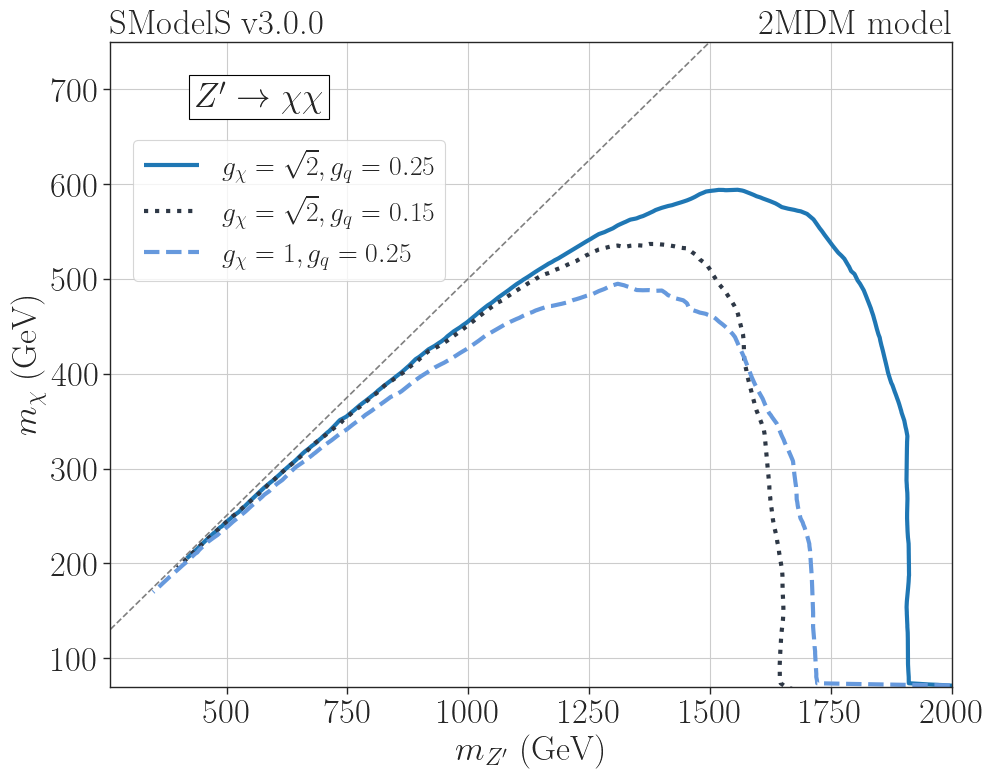

In [86]:
plt.figure(figsize=(10,8))


legends = {}
for gTuple, gDF in sorted(combinedGroups, key = lambda x: sum(x[0]), reverse=True):

    rData = gDF['ExptRes.result.r']
    x = gDF['mZp']
    y = gDF['mChi']
    pts = np.array(list(itertools.product(np.linspace(200.,4100.,300),np.linspace(0.,2000.,300))))
    rPts = griddata(list(zip(x,y)),rData,pts)
    pts = pts[~np.isnan(rPts)]
    rPts = rPts[~np.isnan(rPts)]
    cs = plt.tricontour(pts[:,0],pts[:,1],rPts,levels=[1.0], 
                        colors=gqcolorsMono[gTuple], linewidths=3.0,
                        linestyles=gqstylesMono[gTuple])
    # plt.tricontourf(pts[:,0],pts[:,1], rPts, levels=[1.0, max(rPts)], alpha=0.9, colors=gqcolorsMono[gTuple])
    # legends.append(gqLegend[gTuple])
    legends[gqLegend[gTuple]] = cs.legend_elements()[0][0]
    # cs.collections[0].set_label(gqLegend[gTuple])

plt.axline((1, 1), slope=1/2, linestyle='--', color='gray')

plt.title(r'SModelS v3.0.0', loc='left', fontsize=25)
plt.title(r'2MDM model', loc='right', fontsize=25)

plt.ylim(70, 750) 
plt.xlim(260, 2000)

plt.text(0.1,0.9,r'$Z^\prime \to \chi \chi$',fontsize=25,
            bbox=dict(facecolor='white', edgecolor='black'),
            transform = plt.gca().transAxes)


plt.xlabel(r'$m_{Z^{\prime}}$ (GeV)', fontsize=25)
plt.ylabel(r'$m_{\chi}$ (GeV)', fontsize=25)
# plt.legend(handles=legends, fontsize=20, loc='upper left')
plt.legend(handles = legends.values(), labels=legends.keys(), fontsize=20, loc='upper left',  
           bbox_to_anchor=(0.01,0.87))

plt.tight_layout()
plt.grid()

plt.tick_params(axis='both', which='major', labelsize=25)


plt.savefig('./figures/exclusions_2mdm_monojet_curves.png')
plt.show()